In [1]:
from discopy import *
from discopy.function import *

In [2]:
def scalar_mult(scalar):
     return Function('scalar_mult({})'.format(repr(scalar)), Dim(1), Dim(1), lambda x: scalar * x)
    
def scalar_mults(dom, weights):
    result = Id(0)
    for i in range(dom):
        result = result @ scalar_mult(weights[i])
    return result
   
def bias(scalar):
    return Function('bias({})'.format(repr(scalar)), Dim(0), Dim(1), lambda x: np.array([scalar]))

def merge(cod, copies):
    @discofunc(cod * copies, cod, name='merge({}, {})'.format(cod, copies))
    def add(x):
        return np.array([np.sum([x[i + cod * j] for j in range(copies)]) for i in range(cod)])
    return add

def split(dom, copies):
    @discofunc(dom, dom * copies, name='split({}, {})'.format(dom, copies))
    def copy(x):
        return np.concatenate([x for i in range(copies)])
    return copy

@discofunc(1, 1)
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [3]:
def neuron(dom, cod, weights, beta=0): # weights is a 1d array of length dom, beta is a scalar bias
    return scalar_mults(dom, weights) @ bias(beta) >> merge(1, dom + 1) >> sigmoid >> split(1, cod)

In [4]:
neuron(4, 4, [0, 2.1, 0.3, 0.1])

scalar_mult(0) @ scalar_mult(2.1) @ scalar_mult(0.3) @ scalar_mult(0.1) @ bias(0) >> merge(1, 5) >> sigmoid >> split(1, 4)

In [5]:
def layer(dom, cod, weights, biases): # weights is an array of size: cod x dom (note cod = number of neurons)
    neurons = Id(0)                   # biases is a 1d array of length cod
    for i in range(cod):
        neurons = neurons @ neuron(dom, 1, weights[i], biases[i])
    return split(dom, cod) >> neurons

In [6]:
layer(3, 2, [[0, 0, 0], [0, 0, 0]], [0, 0])(np.array([4, 1, 10]))

DeviceArray([0.5, 0.5], dtype=float32)

In [13]:
from discopy import  Word
from discopy.pregroup import Ty, Box, Diagram

s, n = Ty('s'), Ty('n')
Alice = Word('Alice', n)
loves = Word('loves', n.r @ s @ n.l)
Bob =  Word('Bob', n)
who = Word('who', n.r @ n @ s.l @ n)
is_rich = Word('is rich', n.r @ s)

vocab = [Alice, who, is_rich, loves, Bob]

love_box = Box('love_box', n @ n, s)
is_rich_box = Box('is_rich_box', n, s)
who_box0 = Box('who_box0', n, n @ n)
who_box1 = Box('who_box1', n @ s, n)

In [27]:
from discopy.pregroup import PivotalFunctor

ob = {n: n, s: s}
ar = {Alice: Alice,
      Bob: Bob,
      loves: Cap(n.r, n) @ Cap(n, n.l) >> Diagram.id(n.r) @ love_box @ Diagram.id(n.l),
      is_rich: Cap(n.r, n) >> Diagram.id(n.r) @ is_rich_box,
      who: Cap(n.r, n) >> Diagram.id(n.r) @ (who_box0 >> Diagram.id(n) @ Cap(s, s.l) @ Diagram.id(n) >>
                                             who_box1 @ Diagram.id(s.l @ n))
     }

F = PivotalFunctor(ob, ar, ob_cls=Ty, ar_cls=Diagram)

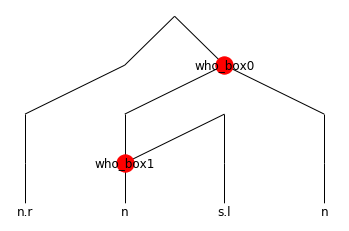

(<networkx.classes.graph.Graph at 0x11c7afb10>,
 {'box_1': (0.0, 3),
  'wire_1_0': (-1.0, 3),
  'wire_2_0': (-2.0, 2),
  'wire_2_1': (-1.0, 2),
  'wire_2_3': (1.0, 2),
  'box_3': (-1.0, 1),
  'wire_3_0': (-2.0, 1),
  'wire_3_2': (0.0, 1),
  'wire_3_3': (1.0, 1),
  'output_0': (-2.0, 0),
  'output_1': (-1.0, 0),
  'output_2': (0.0, 0),
  'output_3': (1.0, 0),
  'wire_0_0': (-0.5, 4),
  'wire_2_2': (0.0, 2)},
 {'box_1': 'who_box0',
  'box_3': 'who_box1',
  'output_0': Ob('n', z=1),
  'output_1': Ob('n'),
  'output_2': Ob('s', z=-1),
  'output_3': Ob('n')})

In [28]:
F(who).draw()

In [29]:
from time import time
from discopy.disco import brute_force

gen, n_sentences = brute_force(*vocab), 20
sentences, parsing = list(), dict()

print("Brute force search for grammatical sentences:")

start = time()
for i in range(n_sentences):
    diagram = next(gen)
    sentence = ' '.join(str(w)
        for w in diagram.boxes if isinstance(w, Word)) + '.'
    sentences.append(sentence)
    parsing.update({sentence: diagram})
    print(sentence)

print("{:.2f} seconds to generate {} sentences.\n".format(time() - start, n_sentences))

Brute force search for grammatical sentences:
Alice is rich.
Bob is rich.
Alice loves Alice.
Alice loves Bob.
Bob loves Alice.
Bob loves Bob.
Alice who is rich is rich.
Bob who is rich is rich.
Alice who is rich loves Alice.
Alice who is rich loves Bob.
Alice who loves Alice is rich.
Alice who loves Bob is rich.
Bob who is rich loves Alice.
Bob who is rich loves Bob.
Bob who loves Alice is rich.
Bob who loves Bob is rich.
Alice who who is rich is rich is rich.
Alice who is rich who is rich is rich.
Alice who loves Alice loves Alice.
Alice who loves Alice loves Bob.
10.22 seconds to generate 20 sentences.



Alice who loves Alice loves Bob.


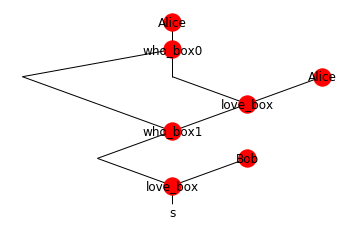

(<networkx.classes.graph.Graph at 0x11c58b190>,
 {'box_0': (-0.5, 7),
  'box_1': (-0.5, 6),
  'box_2': (0.5, 5),
  'wire_2_0': (-1.5, 5),
  'wire_2_1': (-0.5, 5),
  'box_3': (0.0, 4),
  'wire_3_0': (-1.0, 4),
  'box_4': (-0.5, 3),
  'box_5': (0.0, 2),
  'wire_5_0': (-1.0, 2),
  'box_6': (-0.5, 1),
  'output_0': (-0.5, 0)},
 {'box_0': 'Alice',
  'box_1': 'who_box0',
  'box_2': 'Alice',
  'box_3': 'love_box',
  'box_4': 'who_box1',
  'box_5': 'Bob',
  'box_6': 'love_box',
  'output_0': Ob('s')})

In [39]:
print(sentences[19])
F(parsing[sentences[19]]).normal_form().draw()